In [34]:
reset -fs

In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rfpimp import *

In [36]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

# Load data

In [37]:
# Features data.
X = df.drop('y', axis=1)
# One-hot encode categorical features.
X = pd.get_dummies(X)
# Labels data.
y = df['y']
y = y.map({'no': 0, 'yes': 1})

# Train test split

In [38]:
# Train-test-split on data.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [39]:
numeric_features = ['age', 'campaign', 'cons.price.idx', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx',
                            'euribor3m', 'nr.employed']
categorical_features = ['job', 'education', 'default', 'housing',
                            'loan', 'campaign', 'poutcome', 'marital', 'contact', 'month', 'day_of_week']
    

# Feature selection metric: OOB accuracy for scikit-learn RF classifier.

In [40]:
def oob_classifier_accuracy(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

# Method 1: Drop Column 

<b>Drop-column pros/cons</b>

• Easy to understand

• Simple to implement

• Very direct means of measuring importance

• Works for any machine learning model

• BUT, very expensive because it means retraining the model p
times for p features; try on a subset of the data for speed

• Codependent features often result in 0 or very low importance

In [41]:
# drop column
def dropcol_importances(model, X_train, y_train, metric):
    model.fit(X_train, y_train)
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.fit(X, y_train)
        m = metric(rf, X_train, y_train)
        imp.append(baseline - m)
        
    # create df with feature name and importance (from rfpimp)
    labels = []
    for col in X_train.columns:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I


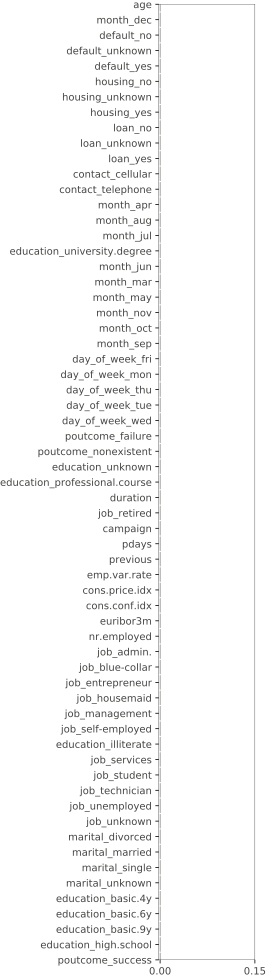

In [42]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, oob_score=True) # default n_estimates = 10
imp_drop = dropcol_importances(rf, X_train, y_train, oob_classifier_accuracy)
plot_importances(imp_drop)

# Method 2: Permutation

<b>Permutation importance pros/cons</b>

• Easy to understand

• Simple to implement

• Works for any machine learning model

• No need to retrain the model so much more efficient than drop
column importance

• Can create nonsensical records through permutation, such as
pregnant male, which makes the results suspect

• Codependent features often share importance, such as longitude
and latitude

• Strobl et al “permutation importance over-estimates the importance of correlated predictor variables”

In [43]:
# permutation
def permutation_importances(rf, X_train, y_train, metric):
    rf.fit(X_train, y_train)
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
        
    # create df with feature name and importance(from rfpimp)
    labels = []
    for col in X_train.columns:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

In [44]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, oob_score=True)
imp_perm = permutation_importances(rf, X_train, y_train, oob_classifier_accuracy)

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

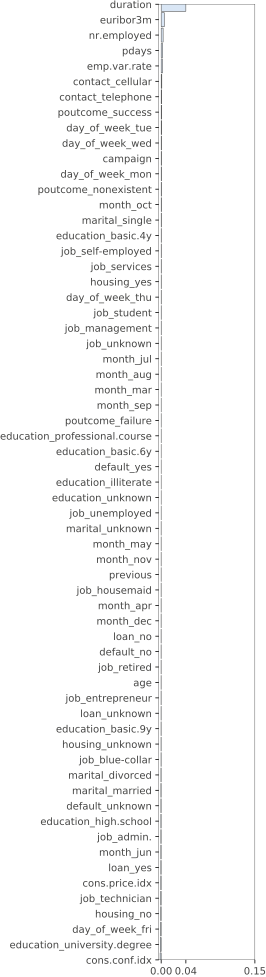

In [45]:
plot_importances(imp_perm)

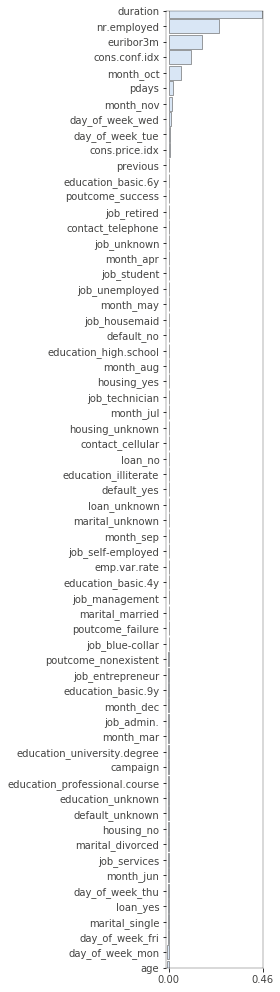

In [46]:
# RFPIMP
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
imp_rfpimp = importances(rf, X_val, y_val)
viz = plot_importances(imp_rfpimp)
#viz.save('file.svg')
#viz.save('file.pdf')
viz.view() # view viz in notebook

# Heatmap for detecting collinear features

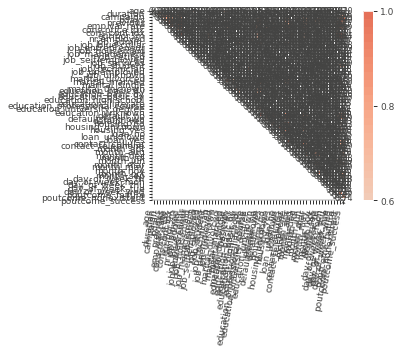

In [47]:
# RFPIMP heatmap sucks
df_train = feature_corr_matrix(X_train)
heatmap = plot_corr_heatmap(df_train, figsize=(7,5))
heatmap.view()

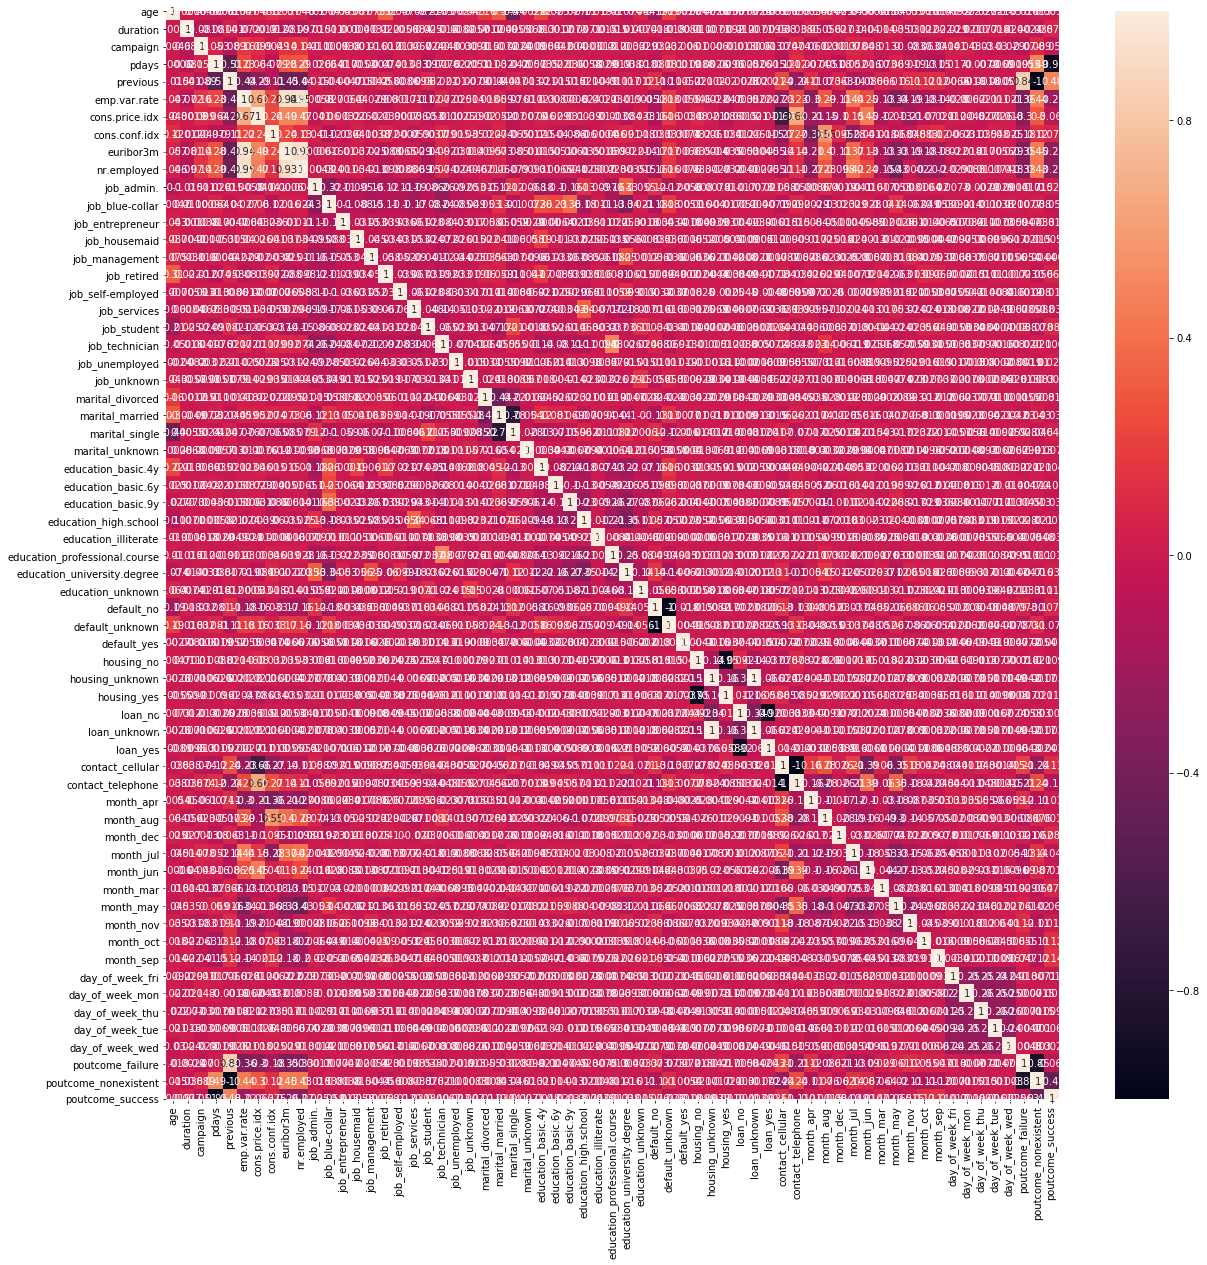

In [48]:
# Prettier heatmap still sucks
import seaborn as sns
#correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
plt.figure(figsize = (20,20))
sns.heatmap(data=df_train, annot=True)

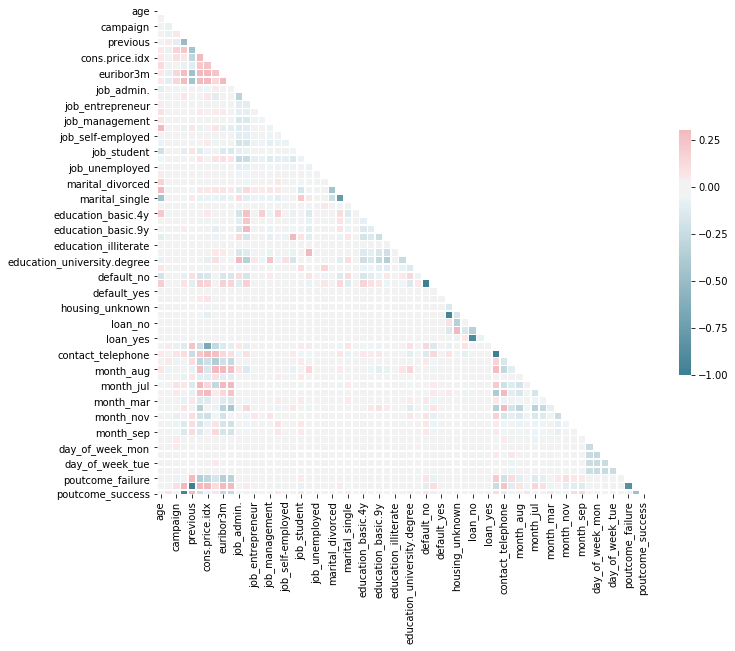

In [50]:
# This one is not the worst!
mask = np.zeros_like(df_train, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_train, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})